In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az # For visualization and loo
#needed for notebook
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_v3_utility

In [3]:
# edit default plot settings
plt.rc('font', size=12)
az.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [7.0, 5.4]

/tmp/ipykernel_357/1626268779.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  az.style.use('seaborn-darkgrid')


## Intially same as 7th assignment but in the end there are evaluations

## 1. Linear model: drowning data with Stan (3p) 

The provided data drowning in the aaltobda package contains the number of people who died from drowning each year in Finland 1980–2019. A statistician is going to fit a linear model with Gaussian residual model to these data using time as the predictor and number of drownings as the target variable (see the related linear model example for the Kilpisjärvi-temperature data in the example Stan codes). She has two objective questions: 

i) What is the trend of the number of people drowning per year? (We would plot the histogram of the slope of the linear model.) 

ii) What is the prediction for the year 2020? (We would plot the histogram of the posterior predictive distribution for the number of people drowning at  ̃ x = 2020.)

To access the data, use:
    
library(aaltobda) 

data("drowning")

Corresponding Stan code is provided in Listing 1. However, it is not entirely correct for the problem. First, there are three mistakes. Second, there are no priors defined for the parameters. In Stan, this corresponds to using uniform priors. Your tasks are the following: 

a) Find the three mistakes in the code and fix them. Report the original mistakes and your fixes clearly in your report. Include the full corrected Stan code in your report. 

Hint: You may find some of the mistakes in the code using Stan syntax checker. If you copy the Stan code to a file ending .stan and open it in RStudio (you can also choose from RStudio menu File→New File→Stan file to create a new Stan file), the editor will show you some syntax errors. More syntax errors might be detected by clicking ‘Check’ in the bar just above the Stan file in the RStudio editor. Note that some of the errors in the presented Stan code may not be syntax errors. 

b) Determine a suitable weakly-informative prior normal(0, σβ) for the slope beta. It is very unlikely that the mean number of drownings changes more than 50 % in one year. The approximate historical mean yearly number of drownings is 138. Hence, set σβ so that the following holds for the prior probability for beta: Pr(−69 < beta < 69) = 0.99. Determine suitable value for σβ and report the approximate numerical value for it. 

c) Using the obtained σβ, add the desired prior in the Stan code. In the report, in a separate section, indicate clearly how you carried out your prior implementation, e.g. “Added line . . . in block . . . ”. 

d) In a similar way, add a weakly informative prior for the intercept alpha and explain how you chose the prior. 

Hint! Example resulting plots for the problem, with the fixes and the desired prior applied, are shown in Figure 1. If you want, you can use these plots as a reference for testing if your modified Stan code produces similar results. However, running the inference and comparing the plots is not required.

In [4]:
df=pd.read_csv('data/drowning.csv')
df.shape

(40, 2)

In [5]:
df.tail()

,year,drownings
35,2015,111
36,2016,87
37,2017,83
38,2018,94
39,2019,90


In [6]:
df.drownings.describe()

count     40.000000
mean     134.350000
std       28.484409
min       83.000000
25%      119.500000
50%      134.000000
75%      144.750000
max      200.000000
Name: drownings, dtype: float64

<Axes: >

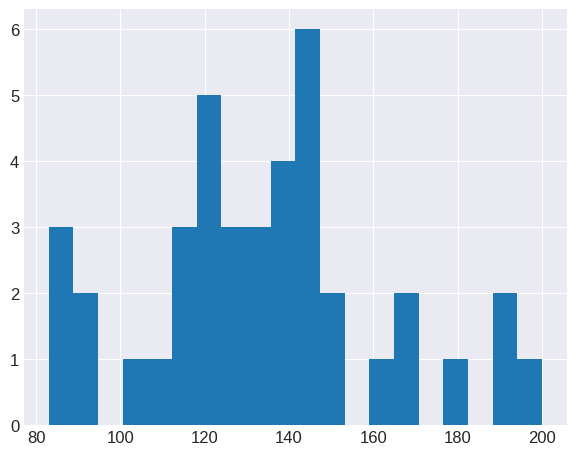

In [7]:
df.drownings.hist(bins=20)

<Axes: xlabel='year', ylabel='drownings'>

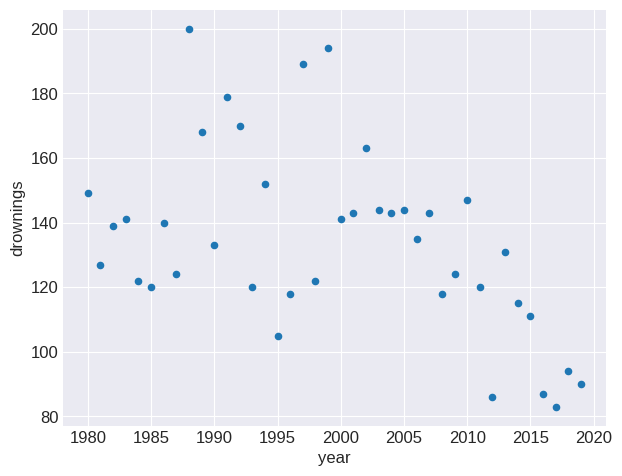

In [8]:
df.plot.scatter(x='year', y='drownings')

### a)

In [9]:
#initial mistaken code
program_code="""
data { 
    int<lower=0> N; // number of data points 
    vector[N] x; // observation year 
    vector[N] y; // observation number of drowned 
    real xpred; // prediction year 
} 
parameters { 
    real alpha; 
    real beta; 
    real<upper=0> sigma; 
} 
transformed parameters { 
    vector[N] mu = alpha + beta*x; 
}
model { 
    y ~ normal(mu, sigma) 
} 
generated quantities { 
    real ypred = normal_rng(mu, sigma); 
}
"""

In [10]:
program_code_corrected="""
data { 
    int<lower=0> N; // number of data points 
    vector[N] x; // observation year 
    vector[N] y; // observation number of drowned 
    real xpred; // prediction year 
} 
parameters { 
    real alpha; 
    real beta; 
    real<lower=0> sigma; 
} 
transformed parameters { 
    vector[N] mu = alpha + beta*x; 
}
model { 
    y ~ normal(mu, sigma);
} 
generated quantities { 
    real ypred = normal_rng(alpha + beta*xpred, sigma);  // fix: use `xpred`
} 
"""

In [11]:
df_renamed=df.rename(columns={'year':'x', 'drownings':'y'})
data={'x':(df.year-df.year.mean()).tolist(), 'y':df.drownings.tolist()}
# data={k:df_renamed[k].tolist() for k in df_renamed.columns}
data['N']=df.shape[0]
data['xpred']=(2020-df.year.mean()).tolist()

In [12]:
model=stan.build(program_code=program_code_corrected, data=data, random_seed=2324)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/lxhnrvsc/model_lxhnrvsc.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 8.3s
Building: 8.4s
Building: 8.5s


/home/jovyan/.cache/httpstan/4.9.1/models/lxhnrvsc/model_lxhnrvsc.cpp: In instantiation of ‘void model_lxhnrvsc_namespace::model_lxhnrvsc::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/lxhnrvsc/model_lxhnrvsc.cpp:442:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/lxhnrvsc/model_lxhnrvsc.cpp:265:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  265 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Buildi

Building: 15.6s, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


### b), c), d)

In [13]:
prior_mean=0
#sd*2.3263=69
sd=69/2.3263
sd=69/stats.norm.ppf(0.995)
sd

26.787489335933042

In [14]:
#how many standard deviations 99.5quantile is away
(69)/stats.norm.ppf(0.99)

29.660224410095537

In [15]:
(-69)/stats.norm.ppf(0.99)

-29.660224410095537

(array([3.0000e+00, 1.6000e+01, 3.7000e+01, 8.7000e+01, 1.7100e+02,
        3.4900e+02, 7.1300e+02, 1.3700e+03, 2.2100e+03, 3.6080e+03,
        5.2790e+03, 7.1260e+03, 8.9100e+03, 1.0295e+04, 1.1169e+04,
        1.1052e+04, 1.0038e+04, 8.4070e+03, 6.6840e+03, 4.8860e+03,
        3.2260e+03, 1.9940e+03, 1.1690e+03, 6.4600e+02, 3.1900e+02,
        1.3400e+02, 6.7000e+01, 2.4000e+01, 7.0000e+00, 4.0000e+00]),
 array([-112.02659058, -104.4965255 ,  -96.96646042,  -89.43639535,
         -81.90633027,  -74.3762652 ,  -66.84620012,  -59.31613504,
         -51.78606997,  -44.25600489,  -36.72593981,  -29.19587474,
         -21.66580966,  -14.13574458,   -6.60567951,    0.92438557,
           8.45445065,   15.98451572,   23.5145808 ,   31.04464587,
          38.57471095,   46.10477603,   53.6348411 ,   61.16490618,
          68.69497126,   76.22503633,   83.75510141,   91.28516649,
          98.81523156,  106.34529664,  113.87536172]),
 <BarContainer object of 30 artists>)

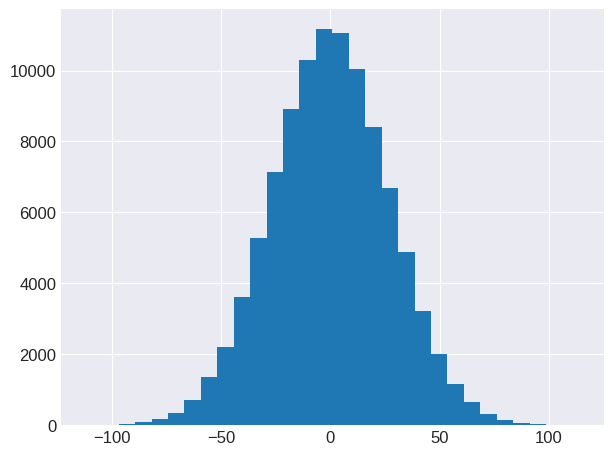

In [16]:
beta_samples=stats.norm.rvs(0, sd, size=100000)
plt.hist(beta_samples, bins=30)

In [17]:
#roughly 69
np.quantile(beta_samples, 0.995)

69.68335338495964

In [18]:
#prior for alpha
#take mean and std of drownings

In [19]:
program_code_corrected_prior="""
data { 
    int<lower=0> N; // number of data points 
    vector[N] x; // observation year 
    vector[N] y; // observation number of drowned 
    real xpred; // prediction year 
} 
parameters { 
    real alpha; 
    real beta; 
    real<lower=0> sigma; 
} 
transformed parameters { 
    vector[N] mu = alpha + beta*x; 
}
model { 
    alpha ~ normal(135,50);
    beta ~ normal(0,26);
    y ~ normal(mu, sigma);
} 
generated quantities { 
    real ypred = normal_rng(alpha + beta*xpred, sigma);  // fix: use "pred" 
} 
"""

In [20]:
model_prior=stan.build(program_code=program_code_corrected_prior, data=data, random_seed=234)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/vjgow4ax/model_vjgow4ax.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 6.9s
Building: 7.0s


/home/jovyan/.cache/httpstan/4.9.1/models/vjgow4ax/model_vjgow4ax.cpp: In instantiation of ‘void model_vjgow4ax_namespace::model_vjgow4ax::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/vjgow4ax/model_vjgow4ax.cpp:448:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/vjgow4ax/model_vjgow4ax.cpp:271:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  271 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 7.1s
Building: 7.2s
Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Buil

Building: 14.8s, done.
Messages from stanc:
Warning in '/tmp/httpstan_ac1_w86d/model_vjgow4ax.stan', line 18, column 20: Argument
    26 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ac1_w86d/model_vjgow4ax.stan', line 17, column 23: Argument
    50 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ac1_w86d/model_vjgow4ax.stan', line 17, column 19: Argument
    135 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [21]:
fit = model_prior.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!


In [22]:
df_fit=fit.to_frame()
df_fit.shape

(4000, 51)

In [23]:
df_fit

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,mu.32,mu.33,mu.34,mu.35,mu.36,mu.37,mu.38,mu.39,mu.40,ypred
draws,,,,,,,,,,,,,,,,,,,,,
0,-145.397210,0.985984,0.743211,3.0,7.0,0.0,145.694518,136.982432,-1.165692,25.885532,...,123.576974,122.411282,121.245590,120.079898,118.914206,117.748514,116.582822,115.417130,114.251438,123.599826
1,-147.943908,0.967899,0.577371,3.0,7.0,0.0,150.517245,132.288949,-1.162145,19.788031,...,118.924280,117.762135,116.599989,115.437844,114.275699,113.113554,111.951409,110.789264,109.627119,125.302297
2,-146.672757,0.946399,0.862180,2.0,7.0,0.0,147.018396,140.840732,-1.258147,24.288423,...,126.372045,125.113899,123.855752,122.597605,121.339459,120.081312,118.823165,117.565019,116.306872,120.808973
3,-148.149404,0.907791,0.821713,3.0,7.0,0.0,149.884053,135.147397,-1.262629,33.959447,...,120.627159,119.364530,118.101900,116.839271,115.576642,114.314012,113.051383,111.788753,110.526124,66.312975
4,-147.564053,0.804150,0.743211,3.0,7.0,0.0,150.404872,141.241683,-1.366249,30.316291,...,125.529821,124.163572,122.797323,121.431074,120.064825,118.698577,117.332328,115.966079,114.599830,92.420787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-146.482421,0.904328,0.821713,2.0,3.0,0.0,148.242829,138.062234,-1.522851,23.466664,...,120.549449,119.026598,117.503747,115.980896,114.458045,112.935195,111.412344,109.889493,108.366642,106.291824
3996,-145.273067,0.987406,0.743211,3.0,7.0,0.0,145.840589,133.031996,-1.061194,25.830576,...,120.828268,119.767075,118.705881,117.644687,116.583493,115.522300,114.461106,113.399912,112.338719,120.964941
3997,-145.508576,0.998681,0.577371,3.0,7.0,0.0,147.854254,137.513780,-1.174151,24.491673,...,124.011040,122.836889,121.662738,120.488586,119.314435,118.140284,116.966132,115.791981,114.617830,111.069897


In [24]:
df_fit.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'alpha', 'beta', 'sigma', 'mu.1', 'mu.2',
       'mu.3', 'mu.4', 'mu.5', 'mu.6', 'mu.7', 'mu.8', 'mu.9', 'mu.10',
       'mu.11', 'mu.12', 'mu.13', 'mu.14', 'mu.15', 'mu.16', 'mu.17', 'mu.18',
       'mu.19', 'mu.20', 'mu.21', 'mu.22', 'mu.23', 'mu.24', 'mu.25', 'mu.26',
       'mu.27', 'mu.28', 'mu.29', 'mu.30', 'mu.31', 'mu.32', 'mu.33', 'mu.34',
       'mu.35', 'mu.36', 'mu.37', 'mu.38', 'mu.39', 'mu.40', 'ypred'],
      dtype='object', name='parameters')

In [25]:
df.shape

(40, 2)

<Axes: >

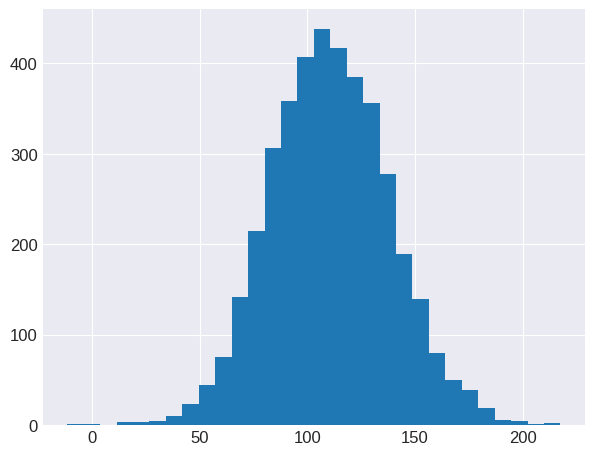

In [26]:
df_fit.ypred.hist(bins=30)

In [27]:
year2019idx=df[df.year==2019].index[0]
year2019idx

39

<Axes: >

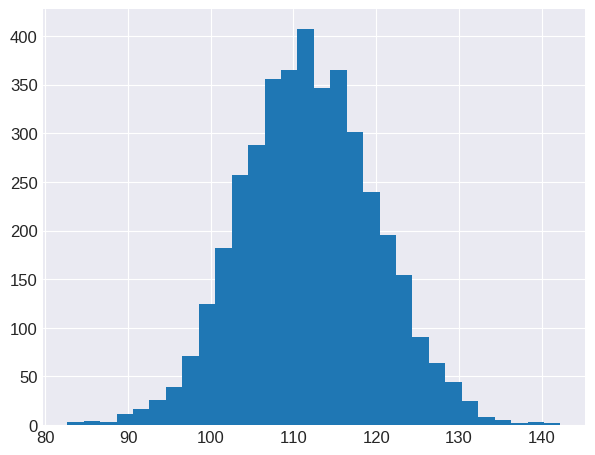

In [28]:
df_fit['mu.40'].hist(bins=30)

<Axes: >

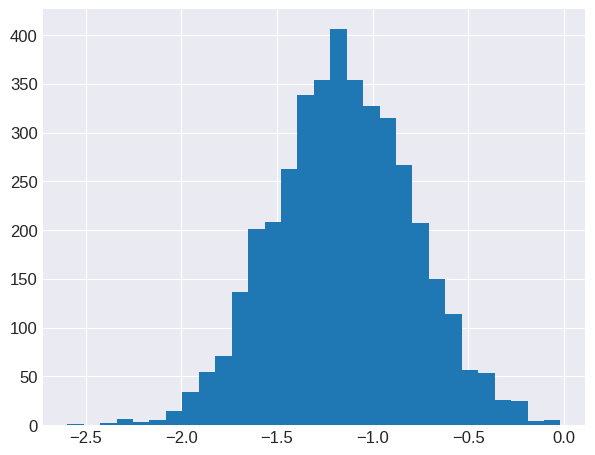

In [29]:
df_fit['beta'].hist(bins=30)

<Axes: >

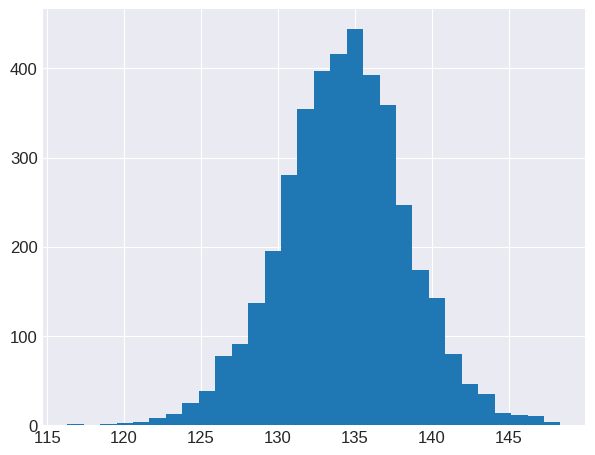

In [30]:
df_fit['alpha'].hist(bins=30)

In [31]:
df_summary=az.summary(fit).T

In [32]:
df_summary

,alpha,beta,sigma,mu[0],mu[1],mu[2],mu[3],mu[4],mu[5],mu[6],...,mu[31],mu[32],mu[33],mu[34],mu[35],mu[36],mu[37],mu[38],mu[39],ypred
mean,134.294,-1.150,26.264,156.725,155.575,154.424,153.274,152.124,150.974,149.823,...,121.066,119.916,118.766,117.615,116.465,115.315,114.164,113.014,111.864,110.621
sd,4.071,0.361,3.082,8.163,7.852,7.546,7.244,6.949,6.660,6.378,...,5.786,6.048,6.320,6.600,6.887,7.182,7.482,7.787,8.097,27.843
hdi_3%,126.024,-1.839,20.726,140.689,140.175,139.347,138.965,138.644,137.921,137.569,...,110.965,108.547,106.894,105.359,103.646,101.972,100.336,98.563,97.385,60.798
hdi_97%,141.450,-0.490,32.057,170.848,169.198,167.278,165.811,164.383,162.663,161.305,...,132.198,130.754,130.118,129.673,129.093,128.591,128.078,127.475,127.354,164.383
mcse_mean,0.067,0.006,0.053,0.127,0.122,0.117,0.112,0.108,0.103,0.099,...,0.098,0.102,0.107,0.111,0.116,0.121,0.126,0.131,0.136,0.456
mcse_sd,0.047,0.004,0.039,0.089,0.086,0.083,0.079,0.076,0.073,0.070,...,0.069,0.072,0.075,0.079,0.082,0.085,0.089,0.092,0.096,0.326
ess_bulk,3711.000,3889.000,3659.000,4165.000,4166.000,4169.000,4174.000,4176.000,4178.000,4180.000,...,3534.000,3543.000,3553.000,3561.000,3569.000,3579.000,3584.000,3587.000,3596.000,3737.000
ess_tail,2509.000,2759.000,2635.000,3008.000,2984.000,2984.000,3033.000,2971.000,2948.000,2941.000,...,2972.000,3109.000,3018.000,2876.000,2854.000,2875.000,2898.000,2897.000,2898.000,3669.000
r_hat,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [33]:
df_summary_mu=df_summary[[c for c in df_summary.columns if 'mu[' in c]]
df_summary_mu.columns=df.year
df_summary_mu

year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
mean,156.725,155.575,154.424,153.274,152.124,150.974,149.823,148.673,147.523,146.372,...,122.216,121.066,119.916,118.766,117.615,116.465,115.315,114.164,113.014,111.864
sd,8.163,7.852,7.546,7.244,6.949,6.660,6.378,6.104,5.841,5.587,...,5.536,5.786,6.048,6.320,6.600,6.887,7.182,7.482,7.787,8.097
hdi_3%,140.689,140.175,139.347,138.965,138.644,137.921,137.569,137.050,135.762,135.568,...,112.604,110.965,108.547,106.894,105.359,103.646,101.972,100.336,98.563,97.385
hdi_97%,170.848,169.198,167.278,165.811,164.383,162.663,161.305,159.749,157.547,156.447,...,132.798,132.198,130.754,130.118,129.673,129.093,128.591,128.078,127.475,127.354
mcse_mean,0.127,0.122,0.117,0.112,0.108,0.103,0.099,0.094,0.090,0.087,...,0.094,0.098,0.102,0.107,0.111,0.116,0.121,0.126,0.131,0.136
mcse_sd,0.089,0.086,0.083,0.079,0.076,0.073,0.070,0.067,0.064,0.061,...,0.066,0.069,0.072,0.075,0.079,0.082,0.085,0.089,0.092,0.096
ess_bulk,4165.000,4166.000,4169.000,4174.000,4176.000,4178.000,4180.000,4193.000,4183.000,4167.000,...,3523.000,3534.000,3543.000,3553.000,3561.000,3569.000,3579.000,3584.000,3587.000,3596.000
ess_tail,3008.000,2984.000,2984.000,3033.000,2971.000,2948.000,2941.000,2897.000,2897.000,2919.000,...,2900.000,2972.000,3109.000,3018.000,2876.000,2854.000,2875.000,2898.000,2897.000,2898.000
r_hat,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


<Axes: xlabel='year'>

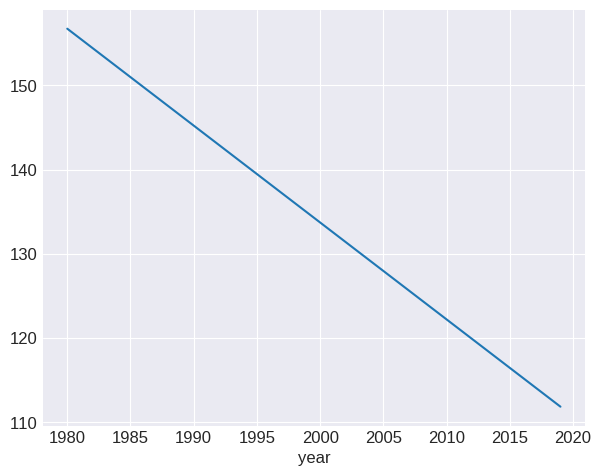

In [34]:
df_summary_mu.T['mean'].plot()

<Axes: xlabel='year', ylabel='drownings'>

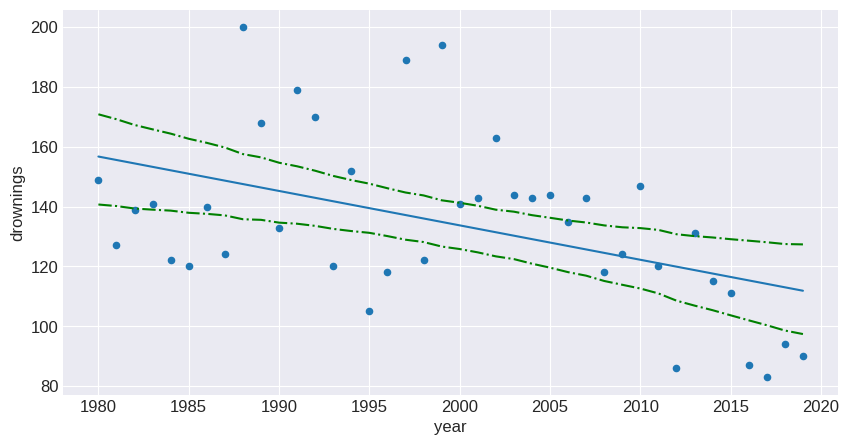

In [35]:
fig, ax =plt.subplots(figsize=(10,5))
ax=df.plot.scatter(x='year', y='drownings', ax=ax)
df_summary_mu.T['mean'].plot(ax=ax)
df_summary_mu.T['hdi_3%'].plot(ax=ax, linestyle='-.', color='green')
df_summary_mu.T['hdi_97%'].plot(ax=ax, linestyle='-.', color='green')

### 2. Hierarchical model: factory data with Stan (3p) 

Note! Both Assignment 8 and 9 build upon this part of the assignment, so it is important to get this assignment correct before you start with Assignment 8 and 9. If you need help, ask TAs. 

The factory data in the aaltobda package contains quality control measurements from 6 machines in a factory (units of the measurements are irrelevant here). In the data file, each column contains the measurements for a single machine. Quality control measurements are expensive and time-consuming, so only 5 measurements were done for each machine. In addition to the existing machines, we are interested in the quality of another machine (the seventh machine). To read in the data, just use:

library(aaltobda) 

data("factory")

For this problem, you’ll use the following Gaussian models: 

• a separate model, in which each machine has its own model 

• a pooled model, in which all measurements are combined and there is no distinction between machines 

• a hierarchical model, which has a hierarchical structure as described in BDA3 Section 11.6 

As in the model described in the book, use the same measurement standard deviation σ for all the groups in the hierarchical model. In the separate model, however, use separate measurement standard deviation σj for each group j. You should use weakly informative priors for all your models. 

The provided Stan code in Listing 2 given on the next page is an example of the separate model (but with very strange results, why?). This separate model can be summarized mathematically as:

yij ∼ N (μj, σj) 

μj ∼ N (0, 1) 

σj ∼ Inv-χ2(10)

To run Stan for that model, simply use:
    
library(cmdstanr)

data("factory")

sm <- cmdstan_model(stan_file = "[path to stan model code]")

stan_data <- list( 
    y = factory, 
    N = nrow(factory), 
    J = ncol(factory) ) 
    
model <- sm$sample(data = stan_data, refresh=1000) 

model

Inference for Stan model: 5cbfa723dd8fb382e0b647b3943db079. ## 4 chains, each with iter=2000; warmup=1000; thin=1; ## post-warmup draws per chain=1000, total post-warmup draws=4000.

mean se_mean sd 2.5% 25% 50% ## mu[1] 0.11 0.01 0.98 -1.81 -0.56 0.12 0.77 ## mu[2] 0.10 0.01 1.00 -1.86 -0.56 0.10 0.79

Note! These are not the results you would expect to turn in your report. You will need to change the code for the separate model as well.

For each of the three models (separate, pooled, hierarchical), your tasks are the following: 

a) Describe the model with mathematical notation (as is done for the separate model above). Also describe in words the difference between the three models. 

b) Implement the model in Stan and include the code in the report. Use weakly informative priors for all your models. 

c) Using the model (with weakly informative priors) report, comment on and, if applicable, plot histograms for the following distributions:

    i) the posterior distribution of the mean of the quality measurements of the sixth machine. 
    ii) the predictive distribution for another quality measurement of the sixth machine. 
    iii) the posterior distribution of the mean of the quality measurements of the seventh machine.
    
d) Report the posterior expectation for μ1 with a 90% credible interval but using a normal(0, 10) prior for the μ parameter(s) and a Gamma(1, 1) prior for the σ parameter(s). For the hierarchical model, use the normal(0, 10) and Gamma(1, 1) as hyper-priors.

Hint! See the example Stan codes [here](http://avehtari.github.io/BDA_R_demos/demos_rstan/cmdstanr_demo.html#8_comparison_of_k_groups_with_hierarchical_models) for the comparison of k groups with and without the hierarchical structure.

In [36]:
#bad separate model:

model_bad="""
data {
    int<lower=0> N; 
    int<lower=0> J; 
    vector[J] y[N]; 
    }
    
parameters { 
    vector[J] mu;
    vector<lower=0>[J] sigma; 
    }
    
model {
     // priors
     for (j in 1:J){ 
         mu[j] ~ normal(0, 1); 
         sigma[j] ~ inv_chi_square(10); 
             }
             
     // likelihood
     for (j in 1:J) 
         y[,j] ~ normal(mu[j], sigma[j]);
     }
     
generated quantities { 
    real ypred; 
    // Compute predictive distribution 
    // for the first machine 
    ypred = normal_rng(mu[1], sigma[1]); 
    }
"""

In [37]:
#data
df_factory=pd.read_table('data/factory.txt',sep=' ', names=['V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
df_factory

,V1,V2,V3,V4,V5,V6
0,83,117,101,105,79,57
1,92,109,93,119,97,92
2,92,114,92,116,103,104
3,46,104,86,102,79,77
4,67,87,67,116,92,100


<Axes: >

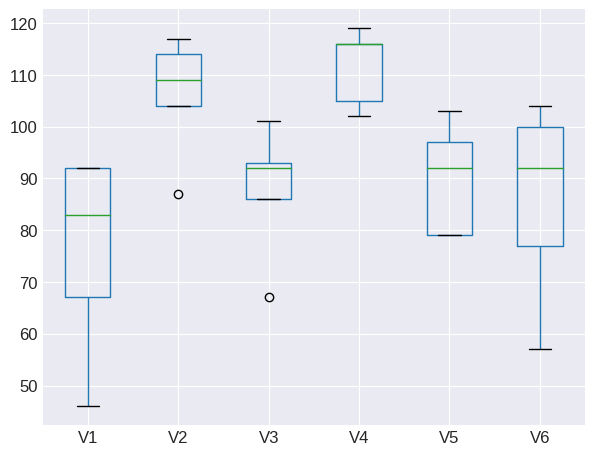

In [38]:
df_factory.boxplot(column=df_factory.columns.tolist())

In [39]:
df_factory.mean(axis=0)

V1     76.0
V2    106.2
V3     87.8
V4    111.6
V5     90.0
V6     86.0
dtype: float64

In [40]:
data_factory={'y':df_factory.values.tolist(),
             'N':df_factory.shape[0],
             'J':df_factory.shape[1]}

In [41]:
data_factory

{'y': [[83, 117, 101, 105, 79, 57],
  [92, 109, 93, 119, 97, 92],
  [92, 114, 92, 116, 103, 104],
  [46, 104, 86, 102, 79, 77],
  [67, 87, 67, 116, 92, 100]],
 'N': 5,
 'J': 6}

### separate model

In [42]:
good_separate_model="""
data {
    int<lower=0> N; 
    int<lower=0> J; 
    vector[J] y[N]; 
    } 
    
parameters { 
    vector[J] mu;
    vector<lower=0>[J] sigma; 
    }
    
model {
     // priors, this one not wrong, down we have more compact way
      //for (j in 1:J){ 
        //  mu[j] ~ normal(0, 1);
         // sigma[j] ~ inv_chi_square(10); 
          //   }
     mu ~ normal(100, 10);     
     sigma ~ inv_chi_square(5);      
     // likelihood
      for (j in 1:J) {
          y[,j] ~ normal(mu[j], sigma[j]);
          }
     } 
  
generated quantities { 
    // Compute the predictive distribution for the sixth machine.
      real y6pred;
      vector[J] log_lik[N];

      y6pred = normal_rng(mu[6], sigma[6]);

      for (j in 1:J) {
        for (n in 1:N) {
          log_lik[n,j] = normal_lpdf(y[n,j] | mu[j], sigma[j]);
        }
    }
  }
"""

In [43]:
model_f_sep=stan.build(program_code=good_separate_model, data=data_factory, random_seed=234)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/snbce4l3/model_snbce4l3.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 7.2s
Building: 7.3s


/home/jovyan/.cache/httpstan/4.9.1/models/snbce4l3/model_snbce4l3.cpp: In instantiation of ‘void model_snbce4l3_namespace::model_snbce4l3::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/snbce4l3/model_snbce4l3.cpp:497:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/snbce4l3/model_snbce4l3.cpp:288:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  288 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
B

Building: 15.8s, done.
Messages from stanc:
Warning in '/tmp/httpstan_ey32tk7c/model_snbce4l3.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ey32tk7c/model_snbce4l3.stan', line 30, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ey32tk7c/model_snbce4l3.stan', line 19, column 17: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [44]:
fit_f_sep = model_f_sep.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!


In [45]:
df_fit_sep=fit_f_sep.to_frame()
df_fit_sep.shape

(4000, 50)

In [46]:
az.summary(fit_f_sep)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],85.780,7.377,72.127,99.557,0.124,0.090,3934.0,2259.0,1.0
mu[1],105.166,4.311,96.947,113.181,0.068,0.048,4170.0,2237.0,1.0
mu[2],90.273,4.831,81.646,99.660,0.092,0.066,3080.0,2170.0,1.0
mu[3],110.536,3.101,104.720,116.184,0.063,0.045,2910.0,1755.0,1.0
mu[4],91.665,3.938,83.869,98.961,0.068,0.048,3603.0,2344.0,1.0
mu[5],91.089,6.312,80.134,104.023,0.099,0.071,4409.0,2499.0,1.0
sigma[0],19.293,6.944,9.298,31.744,0.132,0.096,3496.0,2858.0,1.0
sigma[1],10.453,3.401,5.615,16.762,0.067,0.050,3563.0,2528.0,1.0
sigma[2],11.389,3.750,5.971,17.867,0.074,0.056,3460.0,2620.0,1.0
sigma[3],6.840,2.277,3.537,11.108,0.048,0.036,3132.0,2086.0,1.0


<Axes: >

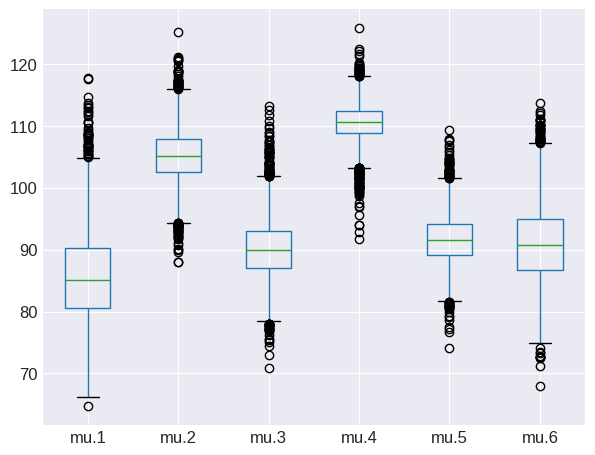

In [47]:
#boxplot from model
df_fit_sep[['mu.1', 'mu.2','mu.3','mu.4','mu.5', 'mu.6']].boxplot(column=['mu.1', 'mu.2','mu.3','mu.4','mu.5', 'mu.6'])

<Axes: >

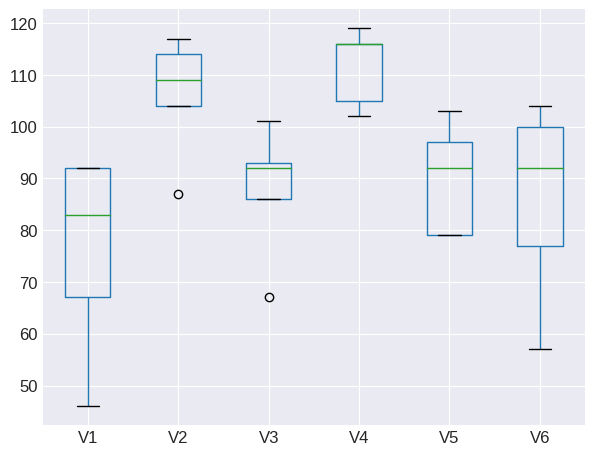

In [48]:
#boxplot from data
df_factory.boxplot(column=df_factory.columns.tolist())

### Pooled model

$$
y_{i} \sim N(\mu, \sigma) \\
\mu \sim N(0, 1) \\
\sigma \sim \text{Inv-}\chi^2(10)
$$

In [49]:
pooled_model="""
data {
    int<lower=0> N; 
    vector[N] y; 
    } 
    
parameters { 
    real mu;
    real<lower=0> sigma; 
    }
    
model {
     // priors
      mu ~ normal(100, 10);
      sigma ~ inv_chi_square(5); 
     
     // likelihood
     y ~ normal(mu, sigma);
          
     } 
  
generated quantities { 
    // Compute the predictive distribution for the sixth machine.
      real y6pred;
      vector[N] log_lik;

      y6pred = normal_rng(mu, sigma);

       for (i in 1:N) {
            log_lik[i] = normal_lpdf(y[i] | mu, sigma);
        }
  }
"""

In [50]:
data_factory_pooled={'y':df_factory.melt()['value'].values.tolist(),
             'N':df_factory.melt().shape[0]}

In [51]:
model_f_pool=stan.build(program_code=pooled_model, data=data_factory_pooled, random_seed=234)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s


In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/vxs65gz3/model_vxs65gz3.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 7.0s
Building: 7.1s


/home/jovyan/.cache/httpstan/4.9.1/models/vxs65gz3/model_vxs65gz3.cpp: In instantiation of ‘void model_vxs65gz3_namespace::model_vxs65gz3::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/vxs65gz3/model_vxs65gz3.cpp:397:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/vxs65gz3/model_vxs65gz3.cpp:223:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  223 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 7.2s
Building: 7.3s
Building: 7.4s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s


Building: 13.8s, done.
Messages from stanc:
Warning in '/tmp/httpstan_1o9f1dur/model_vxs65gz3.stan', line 14, column 18: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [52]:
fit_f_pool = model_f_pool.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!


In [53]:
df_fit_pool=fit_f_pool.to_frame()
df_fit_pool.shape

(4000, 40)

In [54]:
az.summary(fit_f_pool)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,93.602,3.133,87.873,99.763,0.059,0.042,2871.0,1956.0,1.0
sigma,17.689,2.294,13.772,22.059,0.041,0.030,3456.0,2366.0,1.0
y6pred,93.832,17.906,60.776,128.132,0.279,0.198,4117.0,3647.0,1.0


<Axes: >

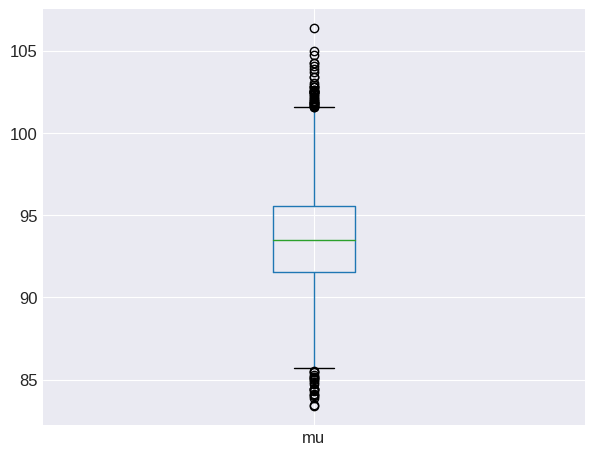

In [55]:
df_fit_pool.boxplot(column='mu')

### Hierarchical model

$$
y_{ij} \sim N(\mu_j, \sigma_j) \\
\mu_j \sim N(\alpha, \tau) \\
\alpha \sim N(0, 1) \\
\tau \sim \text{HalfNormal}(2.5) \\
\sigma \sim \text{Inv-}\chi^2(10)
$$

In [56]:
hierarhical_model="""
data {
    int<lower=0> N; 
    int<lower=0> J; 
    vector[J] y[N]; 
    } 
    
parameters { 
    vector[J] mu;
    real<lower=0> sigma;
    real alpha;
    real<lower=0> tau;
    }
    
model {
     // hyperpriors
      alpha ~ normal(100, 10);
      tau ~ normal(0, 10);
      // priors
      mu ~ normal(alpha, tau);
      sigma ~ inv_chi_square(5); 
     
     // likelihood
      for (j in 1:J) {
              y[,j] ~ normal(mu[j], sigma);
          }
     } 
  
generated quantities { 
    // Compute the predictive distribution for the sixth machine.
      real y6pred;  // Leave for compatibility with earlier assignments.
      vector[J] ypred;
      real mu7pred;
      real y7pred;
      vector[J] log_lik[N];

      y6pred = normal_rng(mu[6], sigma);
      for (j in 1:J) {
        ypred[j] = normal_rng(mu[j], sigma);
      }

      mu7pred = normal_rng(alpha, tau);
      y7pred = normal_rng(mu7pred, sigma);

      for (j in 1:J) {
        for (n in 1:N) {
          log_lik[n,j] = normal_lpdf(y[n,j] | mu[j], sigma);
        }
      }
  }
"""

In [57]:
model_f_hierach=stan.build(program_code=hierarhical_model, data=data_factory, random_seed=234)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.1s
Building: 

In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s


/home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp: In instantiation of ‘void model_j4dg3v27_namespace::model_j4dg3v27::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp:559:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp:335:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  335 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 9.5s
Building: 9.6s
Building: 9.7s


In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_a

Building: 9.8s
Building: 9.9s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 

Building: 22.8s, done.
Messages from stanc:
Warning in '/tmp/httpstan_e3llyisj/model_j4dg3v27.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_e3llyisj/model_j4dg3v27.stan', line 35, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_e3llyisj/model_j4dg3v27.stan', line 17, column 21: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [58]:
fit_f_hierarch = model_f_hierach.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [59]:
df_fit_hierarch=fit_f_hierarch.to_frame()
df_fit_hierarch.shape

(4000, 55)

In [60]:
az.summary(fit_f_pool)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,93.602,3.133,87.873,99.763,0.059,0.042,2871.0,1956.0,1.0
sigma,17.689,2.294,13.772,22.059,0.041,0.030,3456.0,2366.0,1.0
y6pred,93.832,17.906,60.776,128.132,0.279,0.198,4117.0,3647.0,1.0


<Axes: >

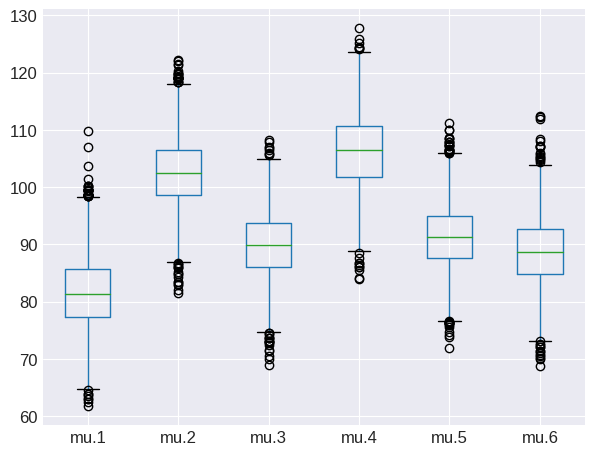

In [61]:
#boxplot from model
df_fit_hierarch[['mu.1', 'mu.2','mu.3','mu.4','mu.5', 'mu.6']].boxplot(column=['mu.1', 'mu.2','mu.3','mu.4','mu.5', 'mu.6'])

### Comparison

/tmp/ipykernel_357/346261970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_means=df_means.append(df_)
/tmp/ipykernel_357/346261970.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_means=df_means.append(df_)
/tmp/ipykernel_357/346261970.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_means=df_means.append(df_)


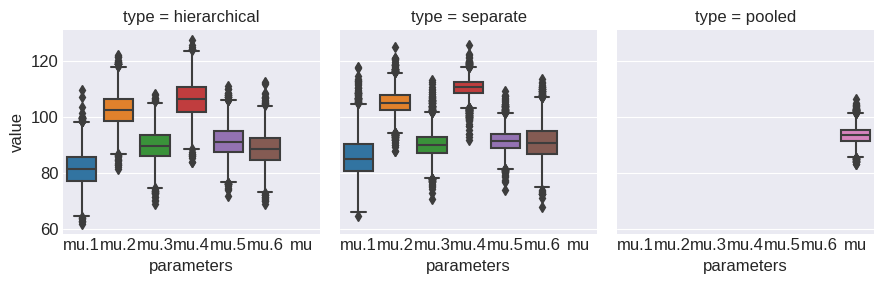

In [62]:
df_means=pd.DataFrame()

df_=df_fit_hierarch[['mu.1', 'mu.2','mu.3','mu.4','mu.5', 'mu.6']].melt()
df_['type']='hierarchical'
df_means=df_means.append(df_)
df_=df_fit_sep[['mu.1', 'mu.2','mu.3','mu.4','mu.5', 'mu.6']].melt()
df_['type']='separate'
df_means=df_means.append(df_)
df_= df_fit_pool[['mu']].melt()
df_['type']='pooled'
df_means=df_means.append(df_)

sns.catplot(
    data=df_means, x='parameters', y='value',
    col='type', kind='box', col_wrap=3, height=3
)

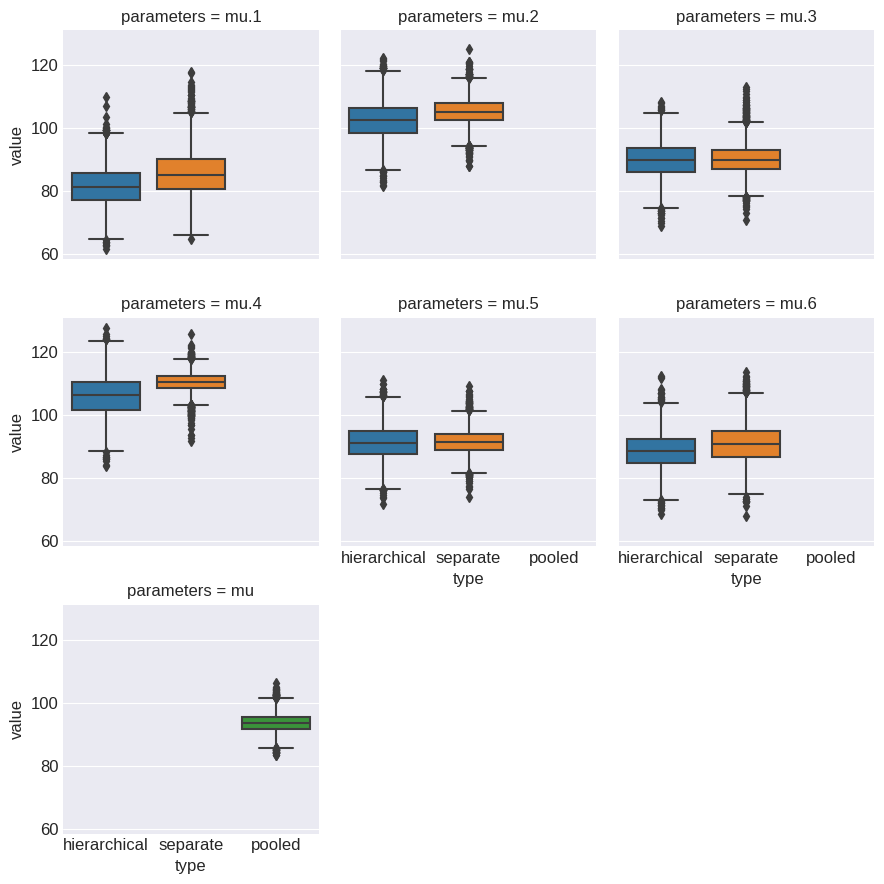

In [63]:
sns.catplot(
    data=df_means, x='type', y='value',
    col='parameters', kind='box', col_wrap=3,
    height=3
)

<Axes: >

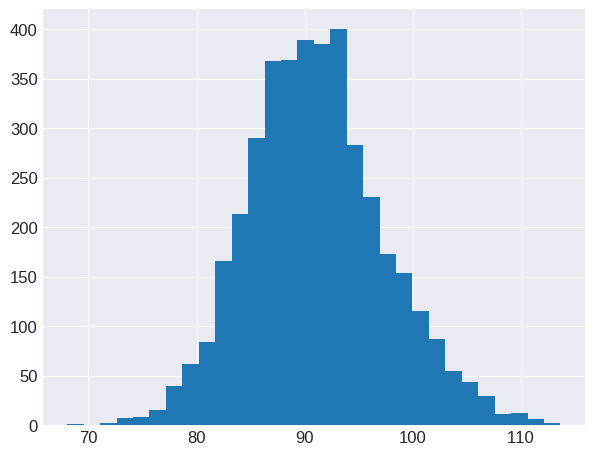

In [64]:
#i) the posterior distribution of the mean of the quality measurements of the sixth machine.
df_fit_sep['mu.6'].hist(bins=30)

<Axes: >

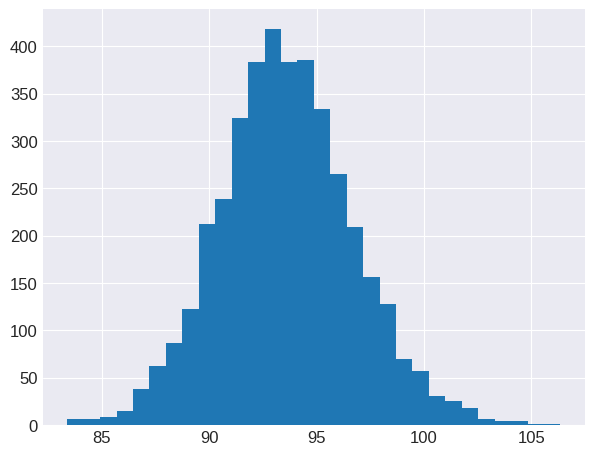

In [65]:
df_fit_pool['mu'].hist(bins=30)

<Axes: >

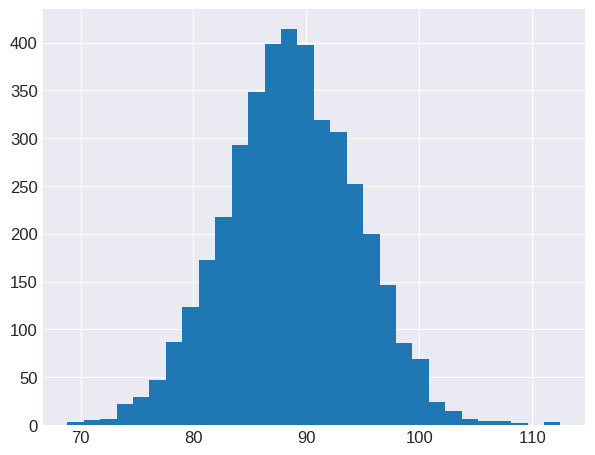

In [66]:
df_fit_hierarch['mu.6'].hist(bins=30)

/tmp/ipykernel_357/3270830817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y6pred_['model']='seprate'
/tmp/ipykernel_357/3270830817.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_y6pred=df_y6pred.append(df_y6pred_)
/tmp/ipykernel_357/3270830817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y6pred_['model']='pooled'
/tmp/ipykernel_357/3270830817.py:8: FutureWarning: The frame.append method is d

<Axes: xlabel='y6pred', ylabel='Count'>

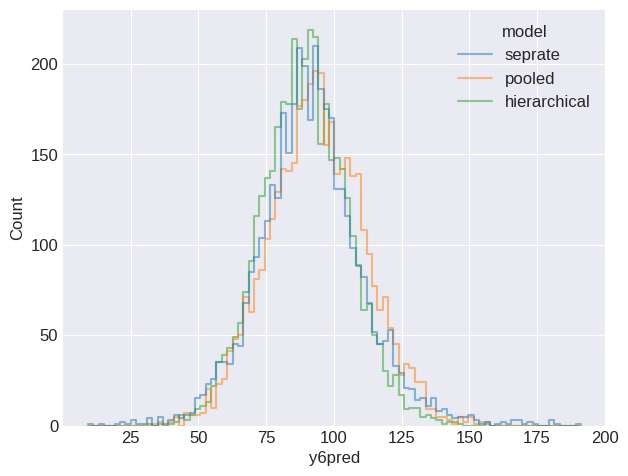

In [67]:
## ii) the predictive distribution for another quality measurement of the sixth machine.
df_y6pred=pd.DataFrame()
df_y6pred_=df_fit_sep[['y6pred']]
df_y6pred_['model']='seprate'
df_y6pred=df_y6pred.append(df_y6pred_)
df_y6pred_=df_fit_pool[['y6pred']]
df_y6pred_['model']='pooled'
df_y6pred=df_y6pred.append(df_y6pred_)
df_y6pred_=df_fit_hierarch[['y6pred']]
df_y6pred_['model']='hierarchical'
df_y6pred=df_y6pred.append(df_y6pred_)

sns.histplot(data=df_y6pred, x="y6pred", hue="model", alpha=0.5, element="step", fill=False)

<Axes: >

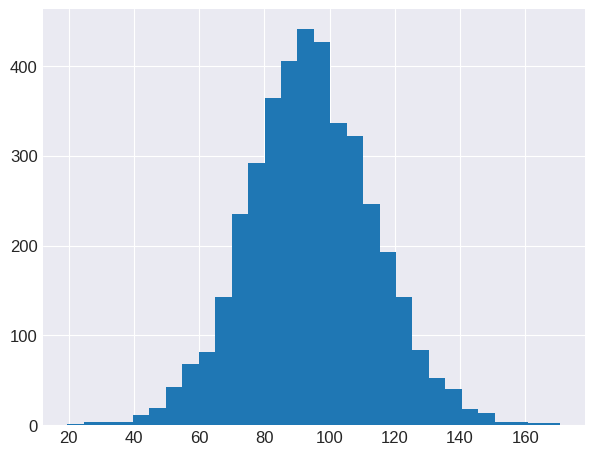

In [68]:
## iii) the posterior distribution of the mean of the quality measurements of the seventh machine.
#for separate model can't predict it because each machine is treated independently
#for pooled model it is same as for all of the machines
df_fit_hierarch.y7pred.hist(bins=30)

### d) Report the posterior expectation for μ1 with a 90% credible interval but using a normal(0, 10) prior for the μ parameter(s) and a Gamma(1, 1) prior for the σ parameter(s). For the hierarchical model, use the normal(0, 10) and Gamma(1, 1) as hyper-priors.

In [69]:
separate_model_prior2="""
data {
    int<lower=0> N; 
    int<lower=0> J; 
    vector[J] y[N]; 
    } 
    
parameters { 
    vector[J] mu;
    vector<lower=0>[J] sigma; 
    }
    
model {
     // priors
     mu ~ normal(0, 1);     
     sigma ~ gamma(1, 1);      
     // likelihood
      for (j in 1:J) {
          y[,j] ~ normal(mu[j], sigma[j]);
          }
     } 
  
generated quantities { 
    // Compute the predictive distribution for the sixth machine.
      real y6pred;
      vector[J] log_lik[N];

      y6pred = normal_rng(mu[6], sigma[6]);

      for (j in 1:J) {
        for (n in 1:N) {
          log_lik[n,j] = normal_lpdf(y[n,j] | mu[j], sigma[j]);
        }
    }
  }
"""

pooled_model_prior2="""
data {
    int<lower=0> N; 
    vector[N] y; 
    } 
    
parameters { 
    real mu;
    real<lower=0> sigma; 
    }
    
model {
     // priors
      mu ~ normal(0,1);
      sigma ~ gamma(1,1); 
     
     // likelihood
     y ~ normal(mu, sigma);
          
     } 
  
generated quantities { 
    // Compute the predictive distribution for the sixth machine.
      real y6pred;
      vector[N] log_lik;

      y6pred = normal_rng(mu, sigma);

       for (i in 1:N) {
            log_lik[i] = normal_lpdf(y[i] | mu, sigma);
        }
  }
"""

hierarhical_model_prior2="""
data {
    int<lower=0> N; 
    int<lower=0> J; 
    vector[J] y[N]; 
    } 
    
parameters { 
    vector[J] mu;
    real<lower=0> sigma;
    real alpha;
    real<lower=0> tau;
    }
    
model {
     // hyperpriors
      alpha ~ normal(0, 1);
      tau ~ gamma(1,1);
      // priors
      mu ~ normal(alpha, tau);
      sigma ~ gamma(1,1); 
     
     // likelihood
      for (j in 1:J) {
              y[,j] ~ normal(mu[j], sigma);
          }
     } 
  
generated quantities { 
    // Compute the predictive distribution for the sixth machine.
      real y6pred;  // Leave for compatibility with earlier assignments.
      vector[J] ypred;
      real mu7pred;
      real y7pred;
      vector[J] log_lik[N];

      y6pred = normal_rng(mu[6], sigma);
      for (j in 1:J) {
        ypred[j] = normal_rng(mu[j], sigma);
      }

      mu7pred = normal_rng(alpha, tau);
      y7pred = normal_rng(mu7pred, sigma);

      for (j in 1:J) {
        for (n in 1:N) {
          log_lik[n,j] = normal_lpdf(y[n,j] | mu[j], sigma);
        }
      }
  }
"""

In [70]:
model_f_sep_prior=stan.build(program_code=separate_model_prior2, data=data_factory, random_seed=234)
model_f_pool_prior=stan.build(program_code=pooled_model_prior2, data=data_factory_pooled, random_seed=234)
model_f_hierach_prior=stan.build(program_code=hierarhical_model_prior2, data=data_factory, random_seed=234)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 

In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/diqkled7/model_diqkled7.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 8.9s
Building: 9.0s


/home/jovyan/.cache/httpstan/4.9.1/models/diqkled7/model_diqkled7.cpp: In instantiation of ‘void model_diqkled7_namespace::model_diqkled7::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/diqkled7/model_diqkled7.cpp:497:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/diqkled7/model_diqkled7.cpp:288:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  288 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s


Building: 18.0s, done.
Messages from stanc:
Warning in '/tmp/httpstan_ju5a4jlw/model_diqkled7.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ju5a4jlw/model_diqkled7.stan', line 26, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.9s
Building: 7.0s
Building: 

In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/7pix2tzf/model_7pix2tzf.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 7.8s
Building: 7.9s


/home/jovyan/.cache/httpstan/4.9.1/models/7pix2tzf/model_7pix2tzf.cpp: In instantiation of ‘void model_7pix2tzf_namespace::model_7pix2tzf::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/7pix2tzf/model_7pix2tzf.cpp:397:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/7pix2tzf/model_7pix2tzf.cpp:223:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  223 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 1

Building: 14.9s, done.


Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/zf7obcik/model_zf7obcik.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 7.9s
Building: 8.0s
Building: 8.1s


/home/jovyan/.cache/httpstan/4.9.1/models/zf7obcik/model_zf7obcik.cpp: In instantiation of ‘void model_zf7obcik_namespace::model_zf7obcik::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/zf7obcik/model_zf7obcik.cpp:559:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/zf7obcik/model_zf7obcik.cpp:335:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  335 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.7s
Building: 14.8s
Building:

Building: 16.2s, done.
Messages from stanc:
Warning in '/tmp/httpstan_43xre1ba/model_zf7obcik.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_43xre1ba/model_zf7obcik.stan', line 35, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [71]:
fit_f_sep_prior = model_f_sep_prior.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/tmp/httpstan_u3l1v2eb/model_diqkled7.stan', line 16, column 5 to column 25)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Excepti

In [72]:
fit_f_pool_prior = model_f_pool_prior.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_7hpnedss/model_7pix2tzf.stan', line 15, column 6 to column 25)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: g

In [73]:
fit_f_hierarch_prior = model_f_hierach_prior.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_8pz6lnzu/model_zf7obcik.stan', line 21, column 6 to column 25)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception:

In [74]:
az.summary(fit_f_sep_prior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.432,1.039,-1.529,2.257,0.010,0.016,10643.0,3018.0,1.0
mu[1],0.412,0.978,-1.516,2.117,0.011,0.016,7998.0,3067.0,1.0
mu[2],0.411,1.024,-1.567,2.309,0.011,0.016,9493.0,3231.0,1.0
mu[3],0.393,1.009,-1.550,2.226,0.011,0.016,8403.0,3068.0,1.0
mu[4],0.426,1.016,-1.451,2.359,0.010,0.015,9686.0,3098.0,1.0
mu[5],0.407,1.008,-1.404,2.377,0.010,0.016,9792.0,2880.0,1.0
sigma[0],30.195,3.110,24.523,36.010,0.035,0.026,8680.0,2672.0,1.0
sigma[1],37.347,3.501,30.687,43.602,0.037,0.027,9631.0,3008.0,1.0
sigma[2],32.881,3.277,26.982,39.155,0.035,0.026,8933.0,2867.0,1.0
sigma[3],38.569,3.542,31.818,45.116,0.040,0.029,7983.0,2846.0,1.0


In [75]:
az.summary(fit_f_pool_prior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.879,1.003,-0.992,2.740,0.018,0.014,3040.0,2707.0,1.0
sigma,56.173,3.762,49.455,63.356,0.065,0.046,3445.0,2513.0,1.0
y6pred,1.630,56.311,-100.198,111.856,0.888,0.633,4015.0,3907.0,1.0


In [76]:
az.summary(fit_f_hierarch_prior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],74.188,5.466,64.354,84.832,0.067,0.047,6696.0,2906.0,1.0
mu[1],103.601,5.400,92.801,113.082,0.070,0.049,6151.0,2551.0,1.0
mu[2],85.719,5.465,74.832,95.722,0.066,0.047,6978.0,3066.0,1.0
mu[3],108.894,5.526,98.231,119.241,0.065,0.046,7293.0,3181.0,1.0
mu[4],87.854,5.419,77.665,98.040,0.067,0.048,6502.0,2913.0,1.0
mu[5],83.984,5.519,73.768,94.507,0.064,0.046,7308.0,3036.0,1.0
sigma,12.189,1.420,9.823,14.988,0.021,0.015,4531.0,3253.0,1.0
alpha,0.451,0.992,-1.321,2.395,0.023,0.018,1893.0,2144.0,1.0
tau,35.507,3.490,28.823,41.818,0.044,0.032,6376.0,3112.0,1.0
y6pred,84.130,13.635,56.447,108.002,0.212,0.151,4125.0,3610.0,1.0


In [77]:
df_fit_sep_prior=fit_f_sep_prior.to_frame()
df_fit_pool_prior=fit_f_pool_prior.to_frame()
df_fit_hierarch_prior=fit_f_hierarch_prior.to_frame()

In [78]:
def plot_col_hist(df, col='mu.1', q0=0.05, q1=0.95):
    ax=df[col].hist(bins=30)
    ax.axvline(np.quantile(df[col], q=0.05), color='red')
    ax.axvline(np.quantile(df[col], q=0.95), color='red')
    plt.show()
    return ax

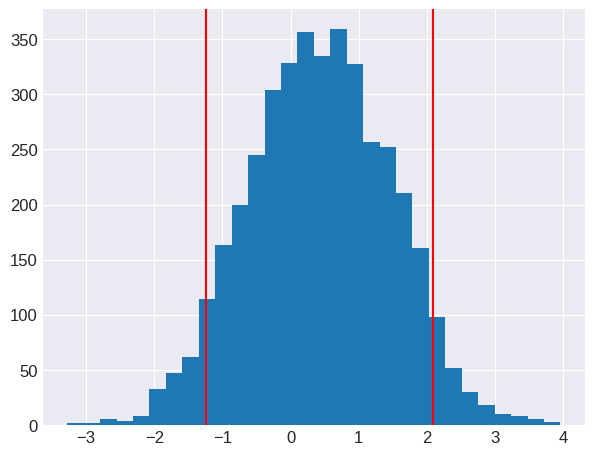

<Axes: >

In [79]:
plot_col_hist(df_fit_sep_prior)

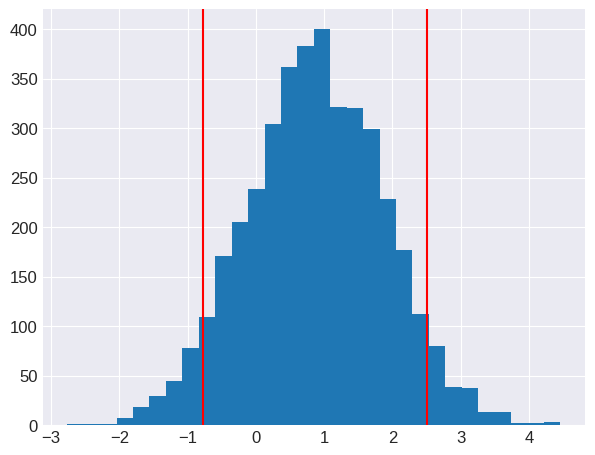

<Axes: >

In [80]:
plot_col_hist(df_fit_pool_prior, 'mu')

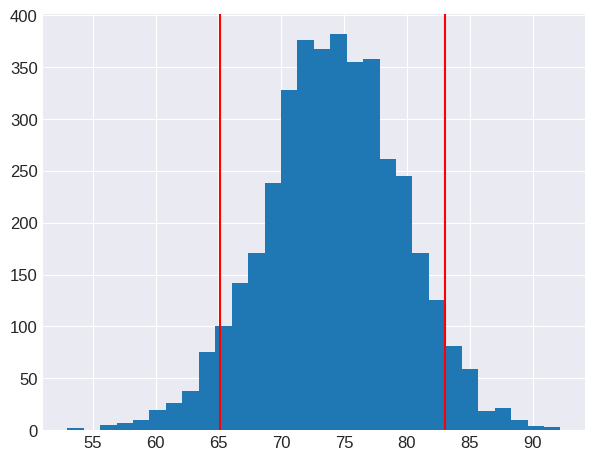

<Axes: >

In [81]:
plot_col_hist(df_fit_hierarch_prior)

## Assignment 9

### Model assessment: LOO-CV for factory data with Stan (6p)

Use leave-one-out cross-validation (LOO-CV) to assess the predictive performance of the pooled,
separate and hierarchical Gaussian models for the factory dataset (see the second exercise in
Assignment 7). To read in the data, just use:

library(aaltobda)

data("factory")

PSIS-LOO is a recently developed method for approximating the exact LOO and is thus not in
BDA3. For more information, see the lecture slides and the original paper.
Use Stan for fitting the models, and the loo R package for computing the approximate LOO-CV
given the posterior samples provided by Stan. You can install the package as

install.packages("loo")

Python users can use PSIS-LOO implementation in ArviZ library.

The report should include the following parts.

1. Fit the models with Stan as instructed in Assignment 7. To use the loo or psisloo
functions, you need to compute the log-likelihood values of each observation for every
posterior draw (i.e. an S-by-N matrix, where S is the number of posterior draws and N = 30
is the total number of observations). This can be done in the generated quantities
block in the Stan code; for a demonstration, see the Gaussian linear model lin.stan in
the R Stan examples that can be found here.
2. Compute the PSIS-LOO elpd values and the ˆk-values for each of the three models.
Hint! It will be convenient to visualize the ˆk-values for each model so that you can easily see
how many of these values fall in the range ˆk > 0.7 to assess the reliability of the PSIS-LOO
estimate for each model. You can read more about the theoretical guarantees for the accuracy
of the estimate depending on ˆk from (see the original article, but regarding this assignment,
it suffices to understand that if all the ˆk-values are ˆk . 0.7, the PSIS-LOO estimate can be
considered to be reliable, otherwise there is a concern that it may be biased (too optimistic,
overestimating the predictive accuracy of the model).
3. Compute the effective number of parameters peff for each of the three models.
Hint! The estimated effective number of parameters in the model can be computed from
equation (7.15) in the book, where elpdloo-cv is the PSIS-LOO value (sum of the LOO log
densities) and lpd is given by equation (7.5) in the book.
4. Assess how reliable the PSIS-LOO estimates are for the three models based on the ˆk-values.
5. An assessment of whether there are differences between the models with regard to the
elpdloo-cv, and if so, which model should be selected according to PSIS-LOO.
6. Both the Stan and R code should be included in your report.

1) log-likelihood values for each model

In [82]:
df_fit_pool_loglik=df_fit_pool_prior[[c for c in df_fit_pool.columns if 'log_lik.' in c]]
df_fit_hierarch_loglik=df_fit_hierarch_prior[[c for c in df_fit_hierarch.columns if 'log_lik.' in c]]
df_fit_sep_loglik=df_fit_sep_prior[[c for c in df_fit_sep.columns if 'log_lik.' in c]]

In [84]:
df_fit_pool_loglik.shape, df_fit_hierarch_loglik.shape, df_fit_sep_loglik.shape

((4000, 30), (4000, 30), (4000, 30))

2) Compute the PSIS-LOO elpd values and the ˆk-values for each of the three models. 

In [85]:
az.loo(fit_f_sep_prior)

Computed from 4000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -255.74     6.56
p_loo       13.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       26   86.7%
 (0.5, 0.7]   (ok)          4   13.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [86]:
az.loo(fit_f_sep)

/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -132.43     7.25
p_loo       14.35        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       21   70.0%
 (0.5, 0.7]   (ok)          2    6.7%
   (0.7, 1]   (bad)         6   20.0%
   (1, Inf)   (very bad)    1    3.3%

In [87]:
az.loo(fit_f_pool_prior)

Computed from 4000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -190.96     2.73
p_loo        0.56        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       30  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [88]:
az.loo(fit_f_pool)

Computed from 4000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -130.93     4.81
p_loo        2.14        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       30  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [89]:
az.loo(fit_f_hierarch_prior)

/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -128.81     5.16
p_loo        9.23        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       27   90.0%
 (0.5, 0.7]   (ok)          1    3.3%
   (0.7, 1]   (bad)         2    6.7%
   (1, Inf)   (very bad)    0    0.0%

In [90]:
az.loo(fit_f_hierarch)

Computed from 4000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -126.90     4.86
p_loo        5.98        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       29   96.7%
 (0.5, 0.7]   (ok)          1    3.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

3) Compute the effective number of parameters peff for each of the three models

In [ ]:
#See p_loo in previous section

4) Assess how reliable the PSIS-LOO estimates are for the three models based on the ˆk-values.

In [105]:
loo_sep=az.loo(fit_f_sep, pointwise=True)

/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

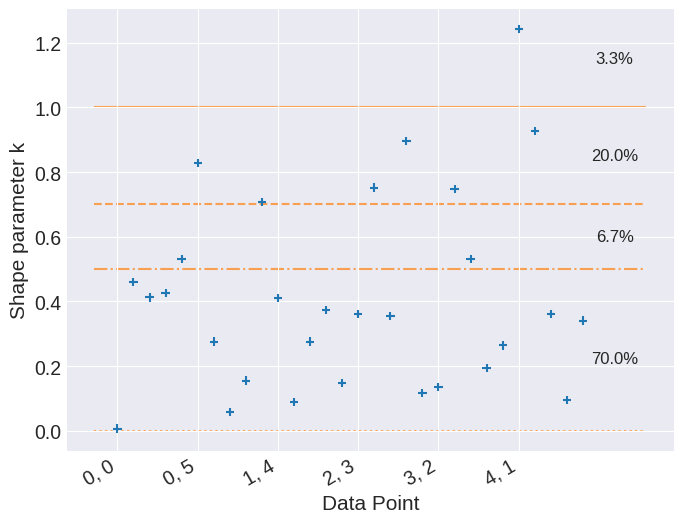

In [107]:
az.plot_khat(loo_sep, show_bins=True, xlabels=True, show_hlines=True)

<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

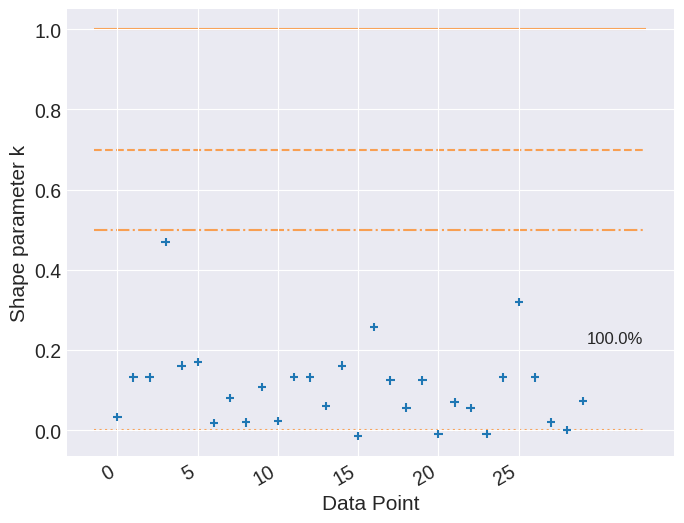

In [108]:
loo_pool=az.loo(fit_f_pool, pointwise=True)
az.plot_khat(loo_pool, show_bins=True, xlabels=True, show_hlines=True)

<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

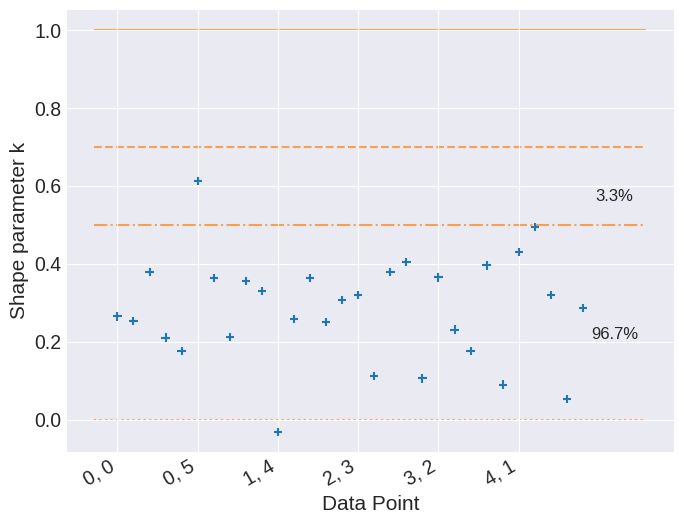

In [109]:
loo_hierarch=az.loo(fit_f_hierarch, pointwise=True)
az.plot_khat(loo_hierarch, show_bins=True, xlabels=True, show_hlines=True)

5) An assessment of whether there are differences between the models with regard to the elpdloo-cv, and if so, which model should be selected according to PSIS-LOO.

In [113]:
df_elpd_loos=pd.DataFrame({'sep':loo_sep.elpd_loo,
                        'pool':loo_pool.elpd_loo,
                        'hierarch':loo_hierarch.elpd_loo}, index=[0])
df_elpd_loos

,sep,pool,hierarch
0,-132.427773,-130.925586,-126.896453


<Axes: >

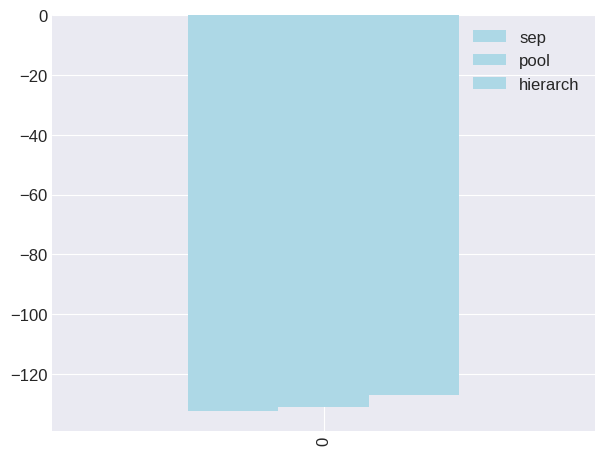

In [117]:
df_elpd_loos.plot(kind='bar', color='lightblue')